# Creating a Radial Turbine/Compressor using PyTurbo-Aero
In this example we will build a simple geometry using PyTurbo-Aero with the intent of simulating with tools such as Numeca or ADS. We'll go over some of the settings required to generated the points in X-R-Theta coordinate system and the theory surrounding m' (m-prime), a non-dimensional coordinate system to visualize 2D turbomachinery blades.


## Theory

Radial machines look a bit strange, the blades are wrapped around an axis. It's often not easy to visualize what each blade cut looks like. We can visualize this in the m' space. M' is the non-dimensional length in the meridional direction so the direction of x-r. Codes such as T-Blade 3 or Mises uses m' to represent a 3D design.

![radial compressor](https://github.com/nasa/pyturbo-aero/blob/main/tutorials/_static/radilal-compressor.jpeg?raw=1)


The equation for m' is below
$$
m' = \int \frac{\sqrt{dx^2+dr^2}}{r}
$$

Note that this integral is with respect to both dx and dr. It can be thought of as the distance along both x and r normalized by the radius. A more simplier representation is:

$$
r_i = \sqrt{x^{2}_i+y^{2}_i}
$$

$$
m'_i = m'_{i-1} + \frac{2}{r_i+r_{i-1}} \sqrt{(r_i-r_{i-1})^2 + {x_i-x_{i-1}^2}}
$$

This is similar to one of those trapezodial integrations where you are summing the previous m' with the currently one divided it by the average radius

> Note: M' at the hub is not the same as mid or tip. It is also not between 0 to 1 either. It's useful for designing the blade profiles in **m',$\theta$** however x,r have to be backed out. The code for centrif approximates m' as a function **f(t,m')** where t goes from 0 to 1. The significance of this is for each t value there's a value of x and r.

# Citations
[Mises Manual](https://web.mit.edu/drela/Public/web/mises/mises.pdf)




In [ ]:
## Install PyTurbo
!pip install pyturbo-aero

## Radial Turbine Example


In [1]:
from pyturbo.aero import Centrif, CentrifProfile, TrailingEdgeProperties
from pyturbo.helper import arc
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt


def build_endwalls(radius:float,inlet_hub_shroud_ratio:float,outlet_hub_shroud_ratio:float,x_stretch_factor:float, rhub_out:float, alpha_start:float=180,alpha_stop:float=270):
    shroud = arc(xc=0,yc=0,radius=radius,alpha_start=alpha_start,alpha_stop=alpha_stop)
    hub = arc(xc=0,yc=0,radius=radius/inlet_hub_shroud_ratio,alpha_start=alpha_start,alpha_stop=alpha_stop)

    [xhub,rhub] = hub.get_point(np.linspace(0,1,100))
    [xshroud,rshroud] = shroud.get_point(np.linspace(0,1,100))

    rhub = rhub/outlet_hub_shroud_ratio
    xhub*=x_stretch_factor
    xshroud*=x_stretch_factor

    hub = np.vstack([xhub,rhub]).transpose()
    shroud = np.vstack([xshroud, rshroud]).transpose()
    shroud[:,1] += -hub[:,1].min() + rhub_out
    hub[:,1] += -hub[:,1].min() + rhub_out
    xshroud += -xhub.min()
    xhub += -xhub.min()
    return hub,shroud

def compute_normals(x:npt.NDArray, y:npt.NDArray):
    # Compute first derivatives
    dx = np.gradient(x)
    dy = np.gradient(y)

    # Compute normal vectors (perpendicular to tangent)
    length = np.hypot(dx, dy)
    nx = -dy / length
    ny = dx / length

    return nx, ny

def offset_curve(x:npt.NDArray, y:npt.NDArray, offset_distance:float):
    nx, ny = compute_normals(x, y)

    # Offset points along the normal direction
    x_offset = x + offset_distance * nx
    y_offset = y + offset_distance * ny

    return x_offset, y_offset

In [2]:
radius = 0.04 # meters
inlet_hub_shroud_ratio = 0.85
outlet_hub_shroud_ratio = 0.8
x_stretch_factor=1.1
rhub_out = 0.009 # meters
nblades = 8 

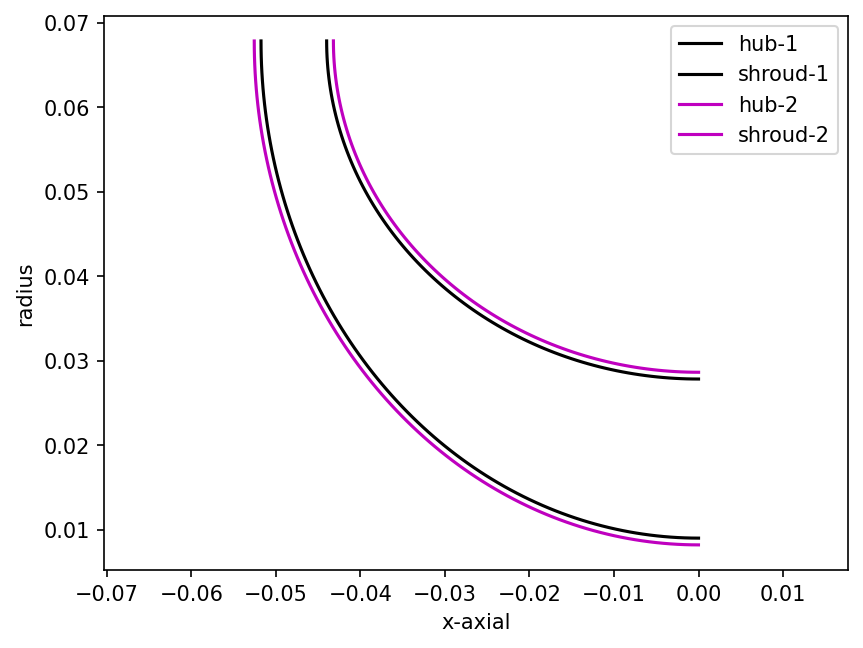

In [3]:
hub1,shroud1 = build_endwalls(radius=radius,
                                inlet_hub_shroud_ratio=inlet_hub_shroud_ratio,outlet_hub_shroud_ratio=outlet_hub_shroud_ratio,
                                x_stretch_factor=x_stretch_factor,rhub_out=rhub_out)
hub2 = offset_curve(hub1[:,0],hub1[:,1],-radius*0.02)
shroud2 = offset_curve(shroud1[:,0],shroud1[:,1],radius*0.02)
hub2 = np.vstack(hub2).transpose()
shroud2 = np.vstack(shroud2).transpose()

# Lets see what it looks like
plt.figure(num=1,clear=True, dpi=150)
plt.plot(hub1[:,0],hub1[:,1],'k',linewidth=1.5,label='hub-1')
plt.plot(shroud1[:,0],shroud1[:,1],'k',linewidth=1.5,label='shroud-1')
plt.plot(hub2[:,0],hub2[:,1],'m',linewidth=1.5,label='hub-2')
plt.plot(shroud2[:,0],shroud2[:,1],'m',linewidth=1.5,label='shroud-2')
plt.xlabel('x-axial')
plt.ylabel('radius')
plt.axis('equal')
plt.legend()
plt.show()
# Note: We are designing for the purple curve however it is cut by the black curve. Black curve is the real hub and shroud. We need to do it like this for CFD mesh generators to find a cut surface.

# Think of it as oversizing the blade and trimming it with the black curve.

In [17]:
from copy import deepcopy

rturbine = Centrif(blade_position=(0.0,1.0),use_mid_wrap_angle=True,
                  use_bezier_thickness=False,
                  use_ray_camber=True)
rturbine.add_hub(hub2[:,0],hub2[:,1])
rturbine.add_shroud(shroud2[:,0],shroud2[:,1])

TE_Cut = False
te_props = TrailingEdgeProperties(TE_Cut=TE_Cut,TE_Radius=0.06)

hub = CentrifProfile(percent_span=0,LE_Thickness=0.10,
                              trailing_edge_properties=te_props,
                              LE_Metal_Angle=0,
                              TE_Metal_Angle=60,
                              LE_Metal_Angle_Loc=0.2,
                              TE_Metal_Angle_Loc=0.8,
                              ss_thickness=[0.12,0.12,0.12,0.12],
                              ps_thickness=[0.12,0.12,0.12,0.12],
                              wrap_angle=-20, # this doesn't matter if you set use_mid_angle_wrap=True
                              wrap_displacements=[0,0],
                              wrap_displacement_locs=[0,0])

mid = CentrifProfile(percent_span=0.5,LE_Thickness=0.06,
                              trailing_edge_properties=te_props,
                              LE_Metal_Angle=0,
                              TE_Metal_Angle=60,
                              LE_Metal_Angle_Loc=0.2,
                              TE_Metal_Angle_Loc=0.8,
                              ss_thickness=[0.07,0.07,0.07,0.05],
                              ps_thickness=[0.07,0.07,0.07,0.05],
                              wrap_angle=-20, # this doesn't matter if you set use_mid_angle_wrap=True
                              wrap_displacements=[0,0],
                              wrap_displacement_locs=[0,0])

tip = CentrifProfile(percent_span=1,LE_Thickness=0.06,
                              trailing_edge_properties=te_props,
                              LE_Metal_Angle=0,
                              TE_Metal_Angle=60,
                              LE_Metal_Angle_Loc=0.2,
                              TE_Metal_Angle_Loc=0.8,
                              ss_thickness=[0.05,0.05,0.05,0.05],
                              ps_thickness=[0.05,0.05,0.05,0.05],
                              wrap_angle=-20, # this doesn't matter if you set use_mid_angle_wrap=True
                              wrap_displacements=[0,0],
                              wrap_displacement_locs=[0,0])

rturbine.add_profile(hub)
rturbine.add_profile(mid)
rturbine.add_profile(tip)

rturbine.build(npts_span=20, npts_chord=100,nblades=nblades)
# s_c_b2b,_ = cen.pitch_to_chord()


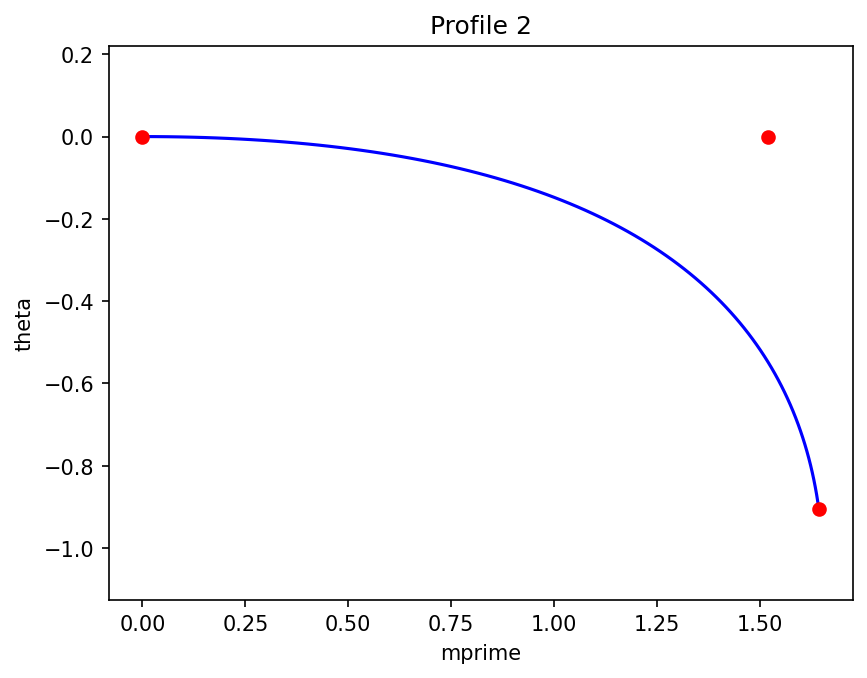

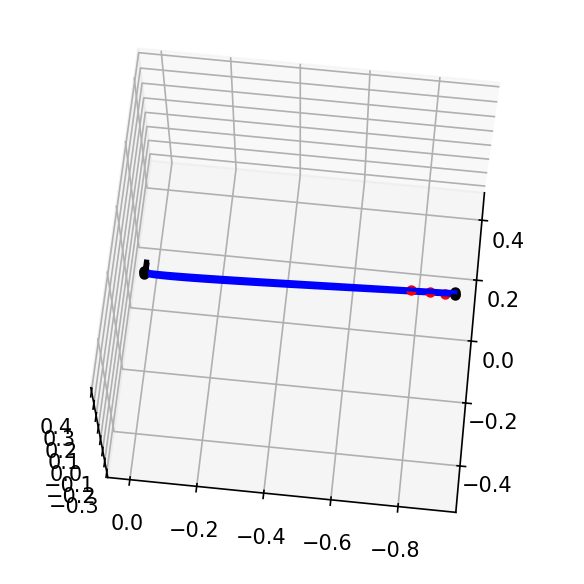

In [18]:
# Plotting the camberline
rturbine.plot_camber()

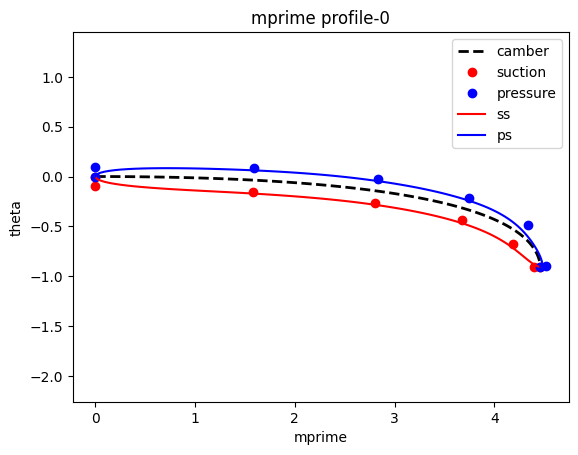

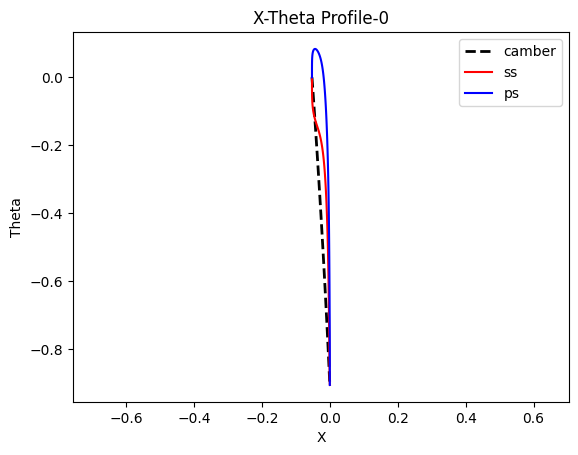

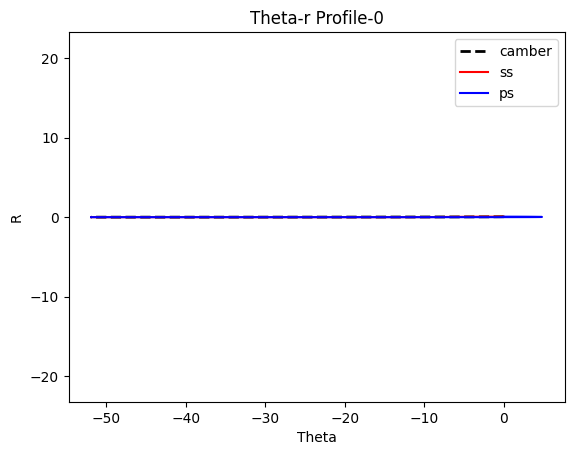

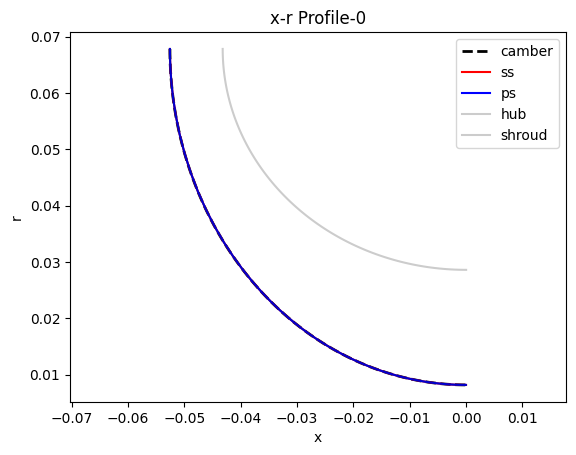

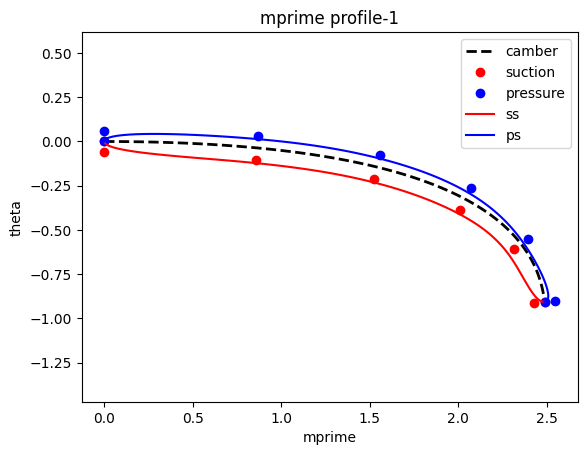

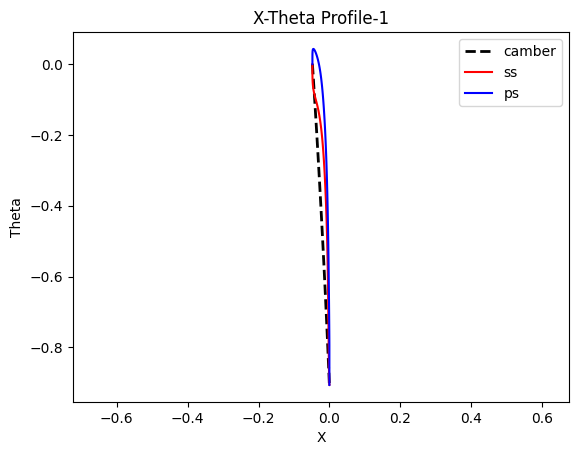

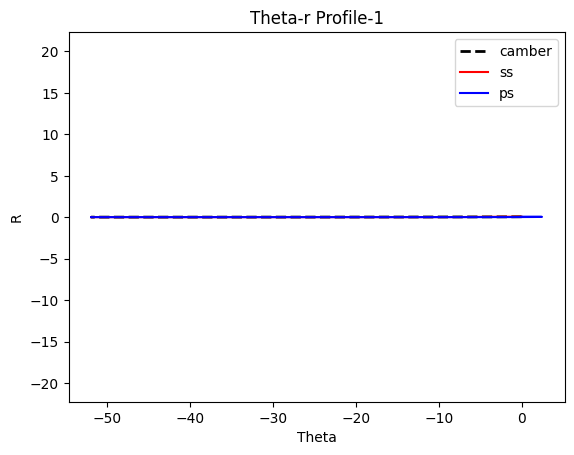

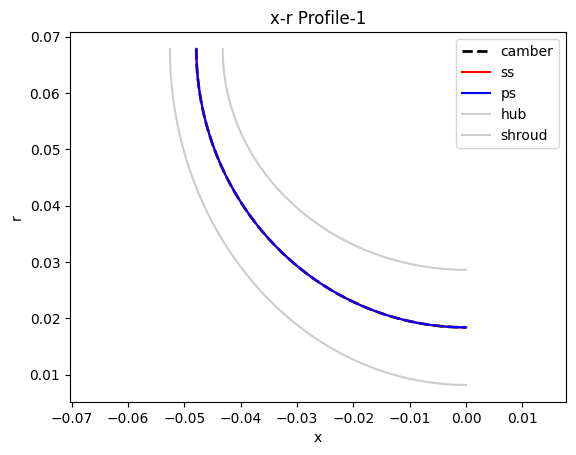

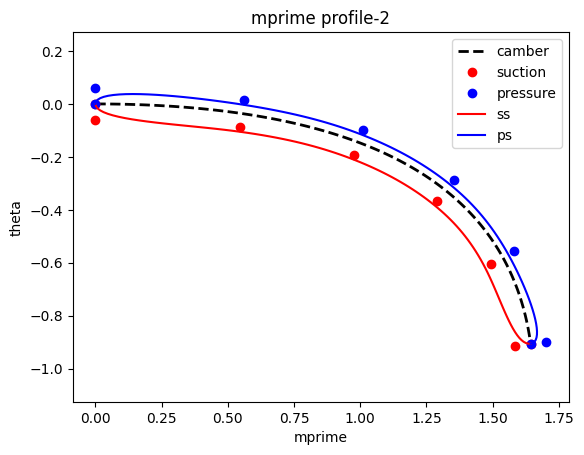

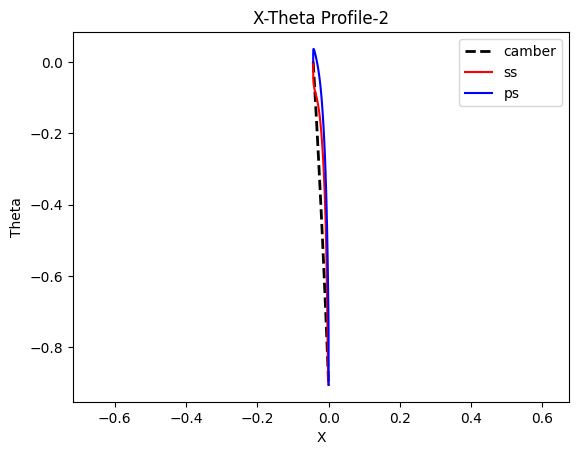

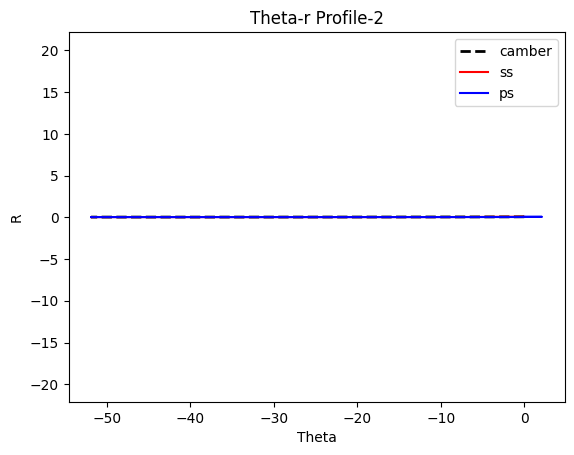

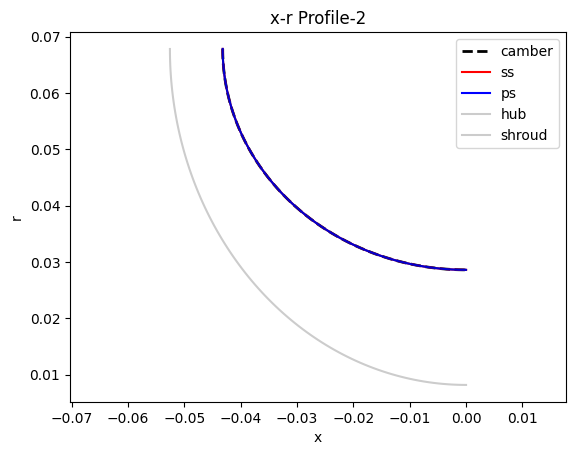

In [19]:
# Plot the mprime
rturbine.plot_mp_profile()


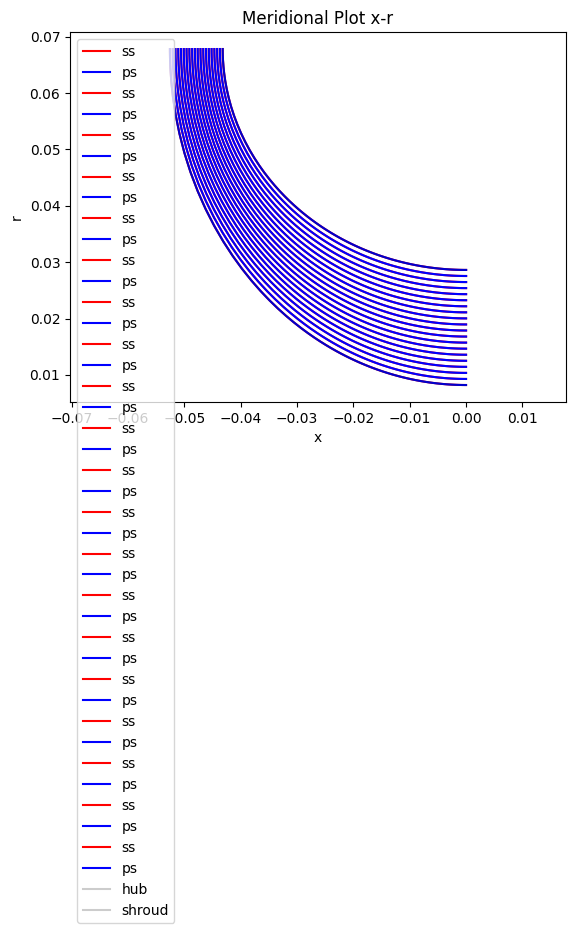

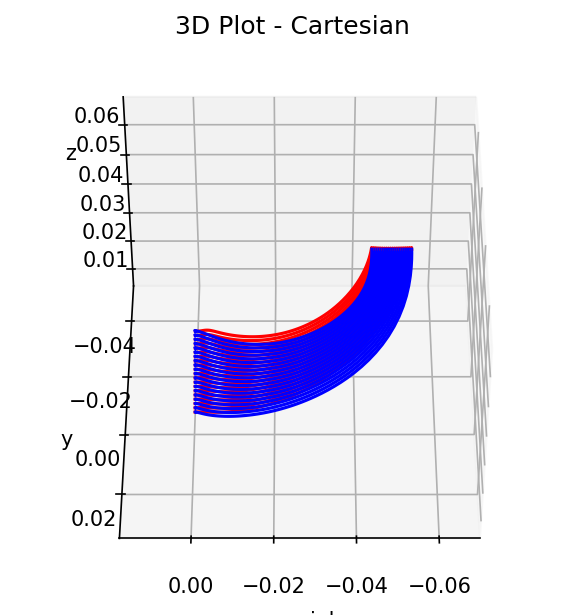

In [20]:
# Plot 3D single blade
rturbine.plot()

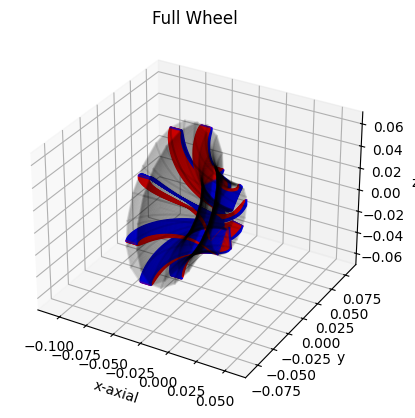

In [21]:
# Plot full wheel
rturbine.plot_fullwheel()

## Centripetal Compressors
Centrif compressures are designed in a similar way to the radial turbine with the exception of the addition of splitter or two splitters 

In [22]:
radius = 0.04 # meters
inlet_hub_shroud_ratio = 0.85
outlet_hub_shroud_ratio = 0.8
x_stretch_factor=1.3
rhub_out = 0.009 # meters
nblades = 8 

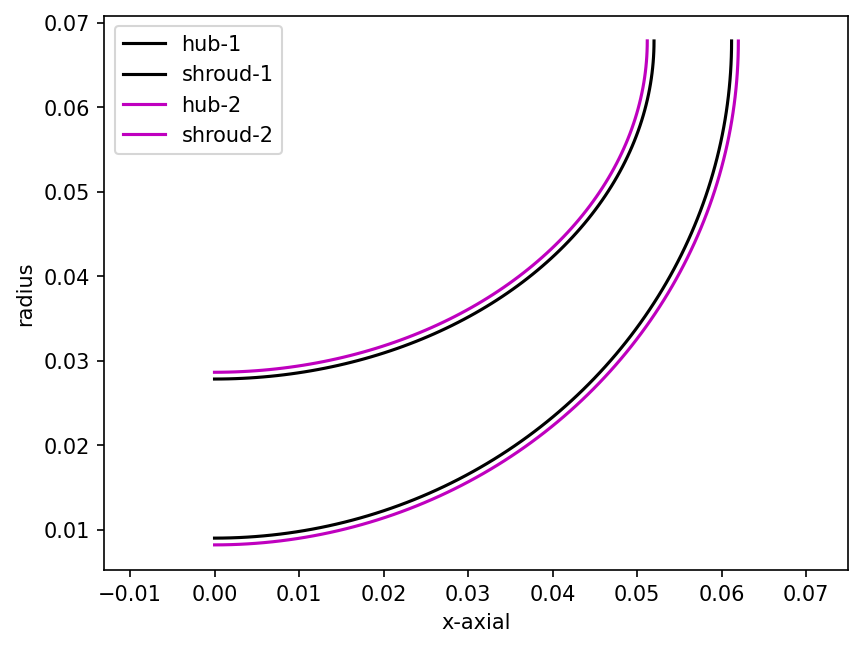

In [24]:
hub1,shroud1 = build_endwalls(radius=radius,
                                inlet_hub_shroud_ratio=inlet_hub_shroud_ratio,
                                outlet_hub_shroud_ratio=outlet_hub_shroud_ratio,
                                x_stretch_factor=x_stretch_factor,
                                rhub_out=rhub_out,
                                alpha_start=270,alpha_stop=360)

hub2 = offset_curve(hub1[:,0],hub1[:,1],-radius*0.02)
shroud2 = offset_curve(shroud1[:,0],shroud1[:,1],radius*0.02)
hub2 = np.vstack(hub2).transpose()
shroud2 = np.vstack(shroud2).transpose()

# Lets see what it looks like
plt.figure(num=1,clear=True, dpi=150)
plt.plot(hub1[:,0],hub1[:,1],'k',linewidth=1.5,label='hub-1')
plt.plot(shroud1[:,0],shroud1[:,1],'k',linewidth=1.5,label='shroud-1')
plt.plot(hub2[:,0],hub2[:,1],'m',linewidth=1.5,label='hub-2')
plt.plot(shroud2[:,0],shroud2[:,1],'m',linewidth=1.5,label='shroud-2')
plt.xlabel('x-axial')
plt.ylabel('radius')
plt.axis('equal')
plt.legend()
plt.show()

In [25]:
cen = Centrif(blade_position=(0.0,1.0),use_mid_wrap_angle=True,
                  use_bezier_thickness=False,
                  use_ray_camber=False)
cen.add_hub(hub2[:,0],hub2[:,1])
cen.add_shroud(shroud2[:,0],shroud2[:,1])

TE_Cut = False
te_props = TrailingEdgeProperties(TE_Cut=TE_Cut,TE_Radius=0.05)
hub = CentrifProfile(percent_span=0,LE_Thickness=0.10,
                              trailing_edge_properties=te_props,
                              LE_Metal_Angle=-50,
                              TE_Metal_Angle=-30,
                              LE_Metal_Angle_Loc=0.1,
                              TE_Metal_Angle_Loc=0.9,
                              ss_thickness=[0.07,0.07,0.07,0.07,0.07],
                              ps_thickness=[0.07,0.07,0.07,0.07,0.07],
                              wrap_angle=-25, # this doesn't matter if you set use_mid_angle_wrap=True
                              wrap_displacements=[0.5,0.5,0.5,0.5],
                              wrap_displacement_locs=[0.3,0.4,0.5,0.7])

te_props = TrailingEdgeProperties(TE_Cut=TE_Cut,TE_Radius=0.05)

mid = CentrifProfile(percent_span=0.5,LE_Thickness=0.06,
                              trailing_edge_properties=te_props,
                              LE_Metal_Angle=-50,
                              TE_Metal_Angle=-30,
                              LE_Metal_Angle_Loc=0.1,
                              TE_Metal_Angle_Loc=0.9,
                              ss_thickness=[0.05,0.05,0.05,0.05,0.05],
                              ps_thickness=[0.05,0.05,0.05,0.05,0.05],
                              wrap_angle=-25, # this doesn't matter if you set use_mid_angle_wrap=True
                              wrap_displacements=[0.5,0.5,0.5,0.5],
                              wrap_displacement_locs=[0.3,0.4,0.5,0.7])

tip = CentrifProfile(percent_span=1,LE_Thickness=0.03,
                              trailing_edge_properties=te_props,
                              LE_Metal_Angle=-50,
                              TE_Metal_Angle=-30,
                              LE_Metal_Angle_Loc=0.1,
                              TE_Metal_Angle_Loc=0.9,
                              ss_thickness=[0.05,0.05,0.05,0.05],
                              ps_thickness=[0.05,0.05,0.05,0.05],
                              wrap_angle=-25, # this doesn't matter if you set use_mid_angle_wrap=True
                              wrap_displacements=[0.5,0.5,0.5,0.5],
                              wrap_displacement_locs=[0.3,0.4,0.5,0.7])

cen.add_profile(hub)
cen.add_profile(mid)
cen.add_profile(tip)
cen.add_splitter([hub,mid,tip],splitter_starts=0.55)

cen.build(npts_span=10, npts_chord=100,nblades=nblades)

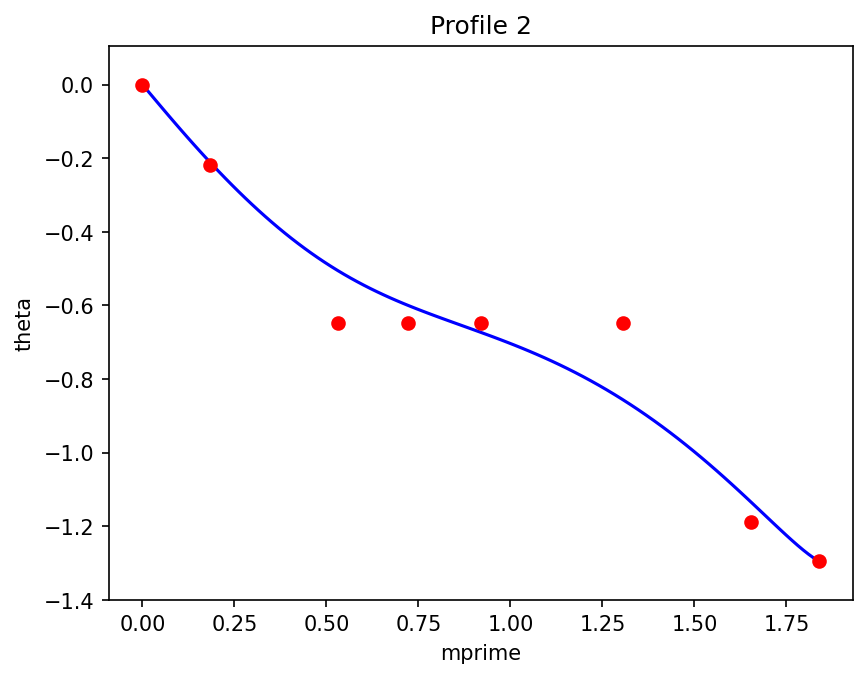

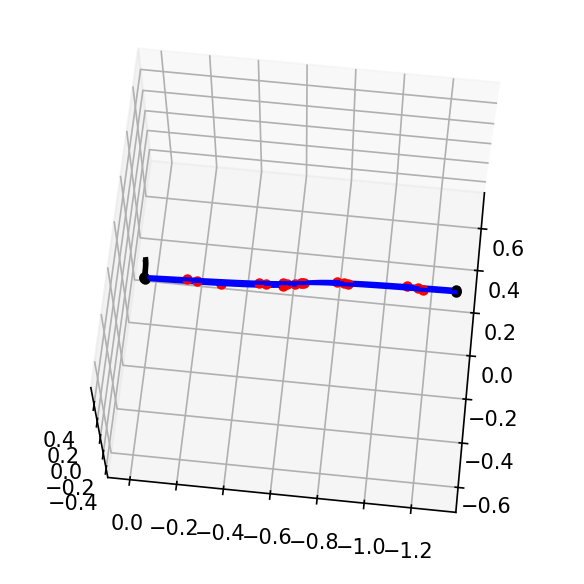

In [26]:
cen.plot_camber()

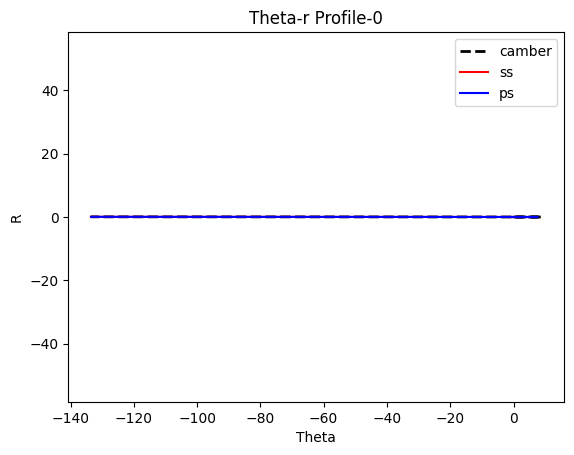

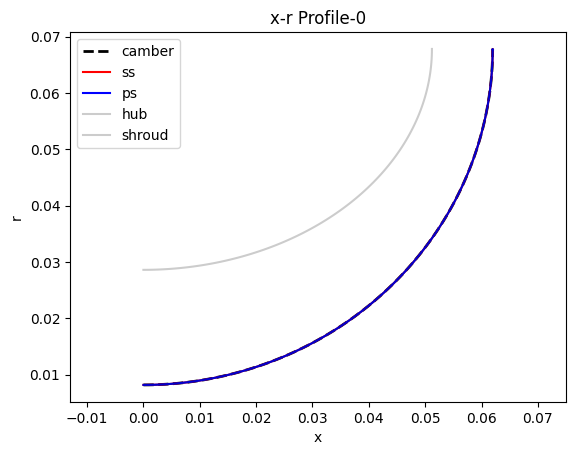

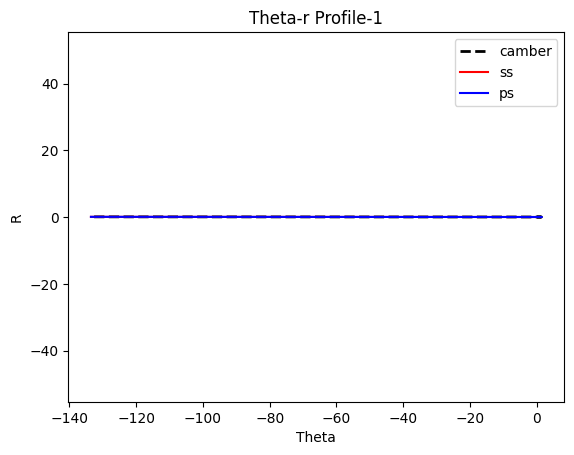

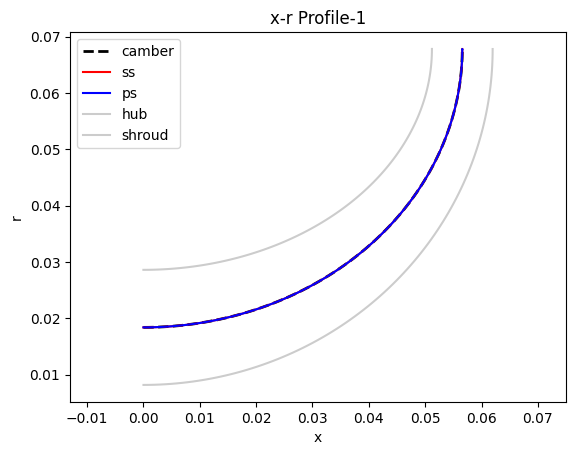

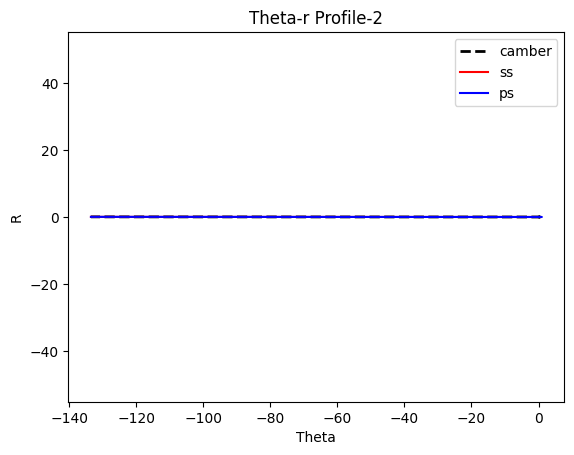

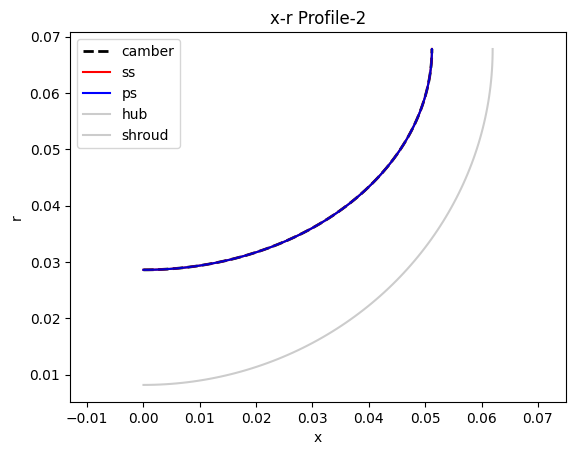

In [37]:
cen.plot_mp_profile()

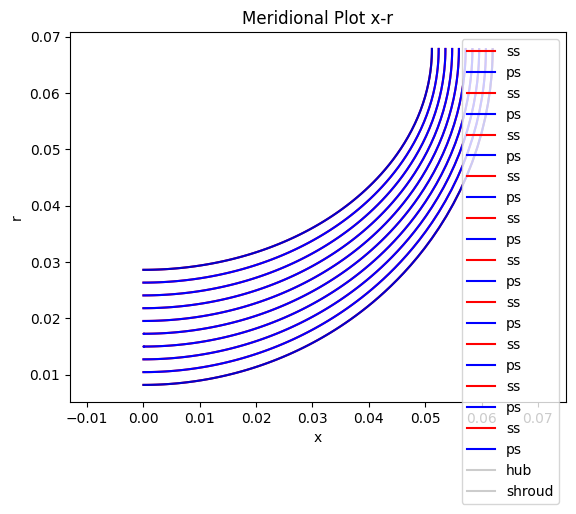

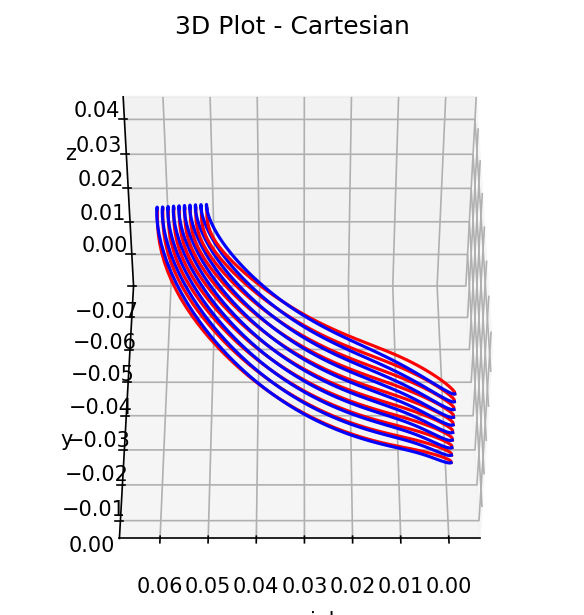

In [27]:
cen.plot()

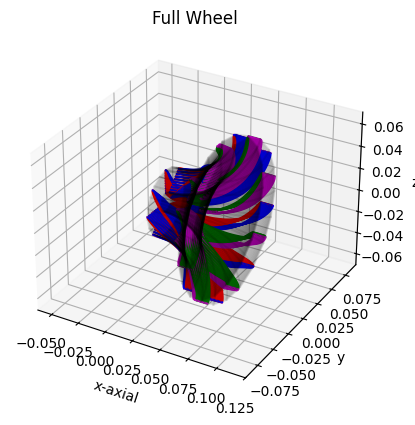

In [28]:
cen.plot_fullwheel()